<a href="https://colab.research.google.com/github/danielriosgarza/sharedColabBooks/blob/main/ModelingMicrobiomesBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all the necessary packages**

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


## Logistic Growth Model

The logistic growth model is a phenomenological model that captures the essential features of population growth in a limited environment. It is particularly useful for modeling bacterial growth, where resources are finite, and the environment can only support a certain maximum population size, known as the carrying capacity.


### Mathematical Representation

For a single species $( N_i )$, the logistic growth equation is:

$\frac{dN_i}{dt} = N_i r_i \left(1 - \frac{N_i}{K_i}\right)$


Where:
- $ \frac{dN_i}{dt} $ is the rate of change of the population size over time.
- $ N_i $ is the population size of species $ i $ at time $ t $.
- $ r_i $ is the intrinsic growth rate of species $ i $.
- $ K_i $ is the carrying capacity of the environment for species $ i $.

### Extending to Multiple Species

When considering multiple species without interactions (e.g., competition or predation), each species can be modeled independently:

$\frac{dN_1}{dt} = N_1 r_1 \left(1 - \frac{N_1}{K_1}\right)$

$\frac{dN_2}{dt} = N_2 r_2 \left(1 - \frac{N_2}{K_2}\right)$

$\vdots$

$\frac{dN_i}{dt} = N_i r_i \left(1 - \frac{N_i}{K_i}\right)$

---

## Components of the Model

### States (Variables)

- **Population Sizes**: $ N_1, N_2, \ldots, N_i $
  - Represent the number of individuals in each species at any given time.
  - **Units**: Number of individuals (cells or density)

### Parameters

1. **Intrinsic Growth Rates**: $ r_1, r_2, \ldots, r_i $
   - The maximum per capita rate of increase when the population is small and resources are abundant.
   - **Units**: Inverse time (e.g., per hour, per day).
   - **Interpretation**: Determines how quickly a species can grow under ideal conditions.

2. **Carrying Capacities**: $ K_1, K_2, \ldots, K_i $
   - The maximum sustainable population size for each species in the environment.
   - **Units**: Number of individuals.
   - **Interpretation**: Reflects the limitation of resources such as nutrients, space, or light.

---



**Define the model**

In [2]:
def logisticModel(t, N, r_values, K_values):
    dNdt = N * r_values * (1 - N / K_values)
    return dNdt


**Define the state space**

In [4]:
# slider widget
num_species_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,#increase for more species
    step=1,
    description='SpeciesNumber',
    continuous_update=True,
    readout=True,
    readout_format='d',
)

# output widget to display the text
output = widgets.Output()

def update_output(change):
    with output:
        output.clear_output()
        print(f"Environment has {num_species_slider.value} microbial species")


num_species_slider.observe(update_output, names='value')

# Display the slider and the output
display(num_species_slider, output)

# Call the function once to display the initial output
update_output(None)


IntSlider(value=3, description='SpeciesNumber', max=10, min=1)

Output()

**Define the parameter values**

In [5]:
# Output widget to hold the parameter input boxes
parameters_output = widgets.Output()

def generate_species_inputs(num_species):
    # Lists to hold the input widgets
    growth_rate_inputs = []
    carrying_capacity_inputs = []
    initial_population_inputs = []

    # Create input boxes for each species
    for i in range(num_species):
        # Growth rate input for species i
        r_input = widgets.FloatText(
            value=0.5,
            description=f'r_{i+1}:',
            step=0.01,
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px'),
        )
        growth_rate_inputs.append(r_input)

        # Carrying capacity input for species i
        K_input = widgets.IntText(
            value=100,
            description=f'K_{i+1}:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px'),
        )
        carrying_capacity_inputs.append(K_input)

        # Initial population input for species i
        N0_input = widgets.IntText(
            value=10,
            description=f'N0_{i+1}:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px'),
        )
        initial_population_inputs.append(N0_input)

    return growth_rate_inputs, carrying_capacity_inputs, initial_population_inputs

def update_parameters(change):
    with parameters_output:
        clear_output()
        # Get the current number of species from the slider
        num_species = num_species_slider.value
        # Generate new input boxes based on the updated number of species
        r_inputs, K_inputs, N0_inputs = generate_species_inputs(num_species)

        # Organize input boxes into boxes for better layout
        inputs_layout = []
        for i in range(num_species):
            species_label = widgets.HTML(value=f"<b>Species {i+1}</b>")
            species_inputs = widgets.VBox([species_label, r_inputs[i], K_inputs[i], N0_inputs[i]])
            inputs_layout.append(species_inputs)

        # Display input boxes in a horizontal box
        display(widgets.HBox(inputs_layout))

        # Store inputs for further use (e.g., in simulations)
        parameters_output.r_inputs = r_inputs
        parameters_output.K_inputs = K_inputs
        parameters_output.N0_inputs = N0_inputs


# Observe changes in the number of species slider
num_species_slider.observe(update_parameters, names='value')


# Initialize the parameter inputs display
update_parameters(None)

# Display the parameter inputs
display(parameters_output)

Output()

**Simulate the model**

Button(button_style='success', description='Run Simulation', style=ButtonStyle(), tooltip='Click to run the si…

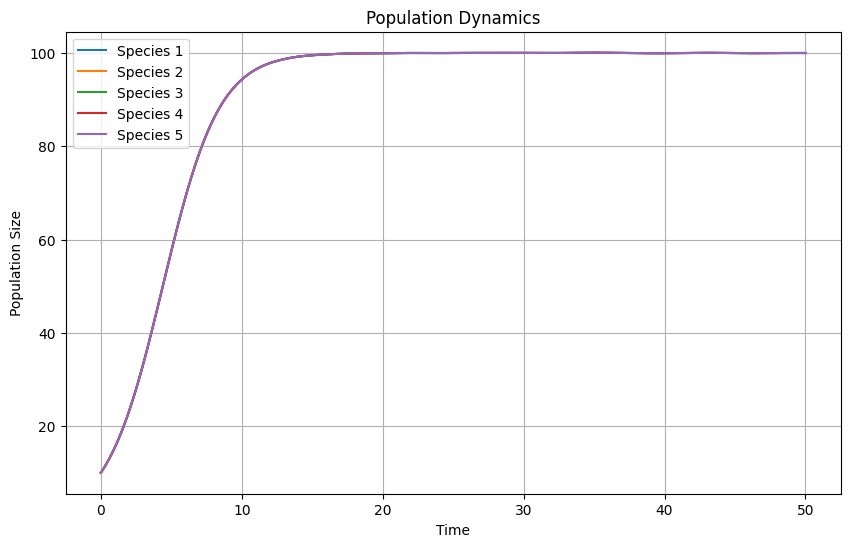

In [6]:
def get_parameter_values():
    # Get the current parameter values
    r_values = [input_widget.value for input_widget in parameters_output.r_inputs]
    K_values = [input_widget.value for input_widget in parameters_output.K_inputs]
    N0_values = [input_widget.value for input_widget in parameters_output.N0_inputs]
    return r_values, K_values, N0_values

def run_simulation(button, tStart = 0, tEnd = 50, tstore = 500):
    try:
        # Retrieve the parameter values
        r_values, K_values, N0_values = get_parameter_values()

        # Convert to NumPy arrays for vectorized operations
        r_values = np.array(r_values, dtype=float)
        K_values = np.array(K_values, dtype=float)
        N0_values = np.array(N0_values, dtype=float)
        num_species = num_species_slider.value

        # Check for invalid inputs
        if np.any(r_values < 0) or np.any(K_values <= 0) or np.any(N0_values < 0):
            raise ValueError("Growth rates, carrying capacities, and initial populations must be non-negative, and carrying capacities must be positive.")

        # Time span and evaluation points
        t_span = (tStart, tEnd)
        t_eval = np.linspace(t_span[0], t_span[1], tstore)

        # Solve the ODEs
        solution = solve_ivp(
            logisticModel,
            t_span,
            N0_values,
            args=(r_values, K_values),  # Pass the parameters to the model function
            t_eval=t_eval,
            method='RK45'
        )

        # Plot the results
        plt.figure(figsize=(10, 6))
        for i in range(num_species):
            plt.plot(solution.t, solution.y[i], label=f"Species {i+1}")
        plt.xlabel('Time')
        plt.ylabel('Population Size')
        plt.title('Population Dynamics')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Create a button to run the simulation
run_button = widgets.Button(
    description='Run Simulation',
    button_style='success',
    tooltip='Click to run the simulation with current parameters',
)

# Attach the simulation function to the button
run_button.on_click(run_simulation)

# Display the button
display(run_button)


**Putting it all together (to make it easier to simulate)**

we make the growth rates drawn from a random uniform distribution betweem 0 and 1, the carrying capacity a random number between 0 and 3, and concentration at $t=0$ equal to 0.01 (more of less the OD600 range).

IntSlider(value=3, description='SpeciesNumber', max=10, min=1)

Output()

Output()

Button(button_style='success', description='Run Simulation', style=ButtonStyle(), tooltip='Click to run the si…

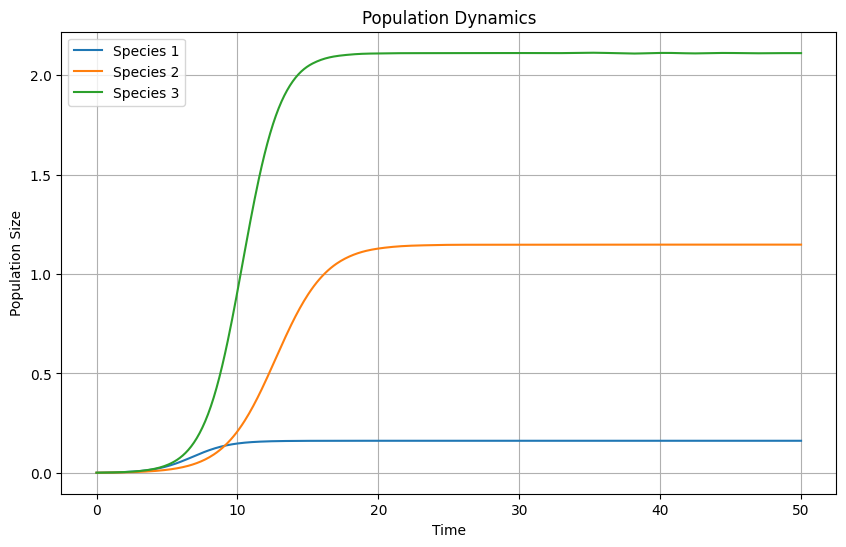

In [7]:

##########Model############

def logisticModel(t, N, r_values, K_values):
    dNdt = N * r_values * (1 - N / K_values)
    return dNdt

###### state-space ############

# slider widget
num_species_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,#increase for more species
    step=1,
    description='SpeciesNumber',
    continuous_update=True,
    readout=True,
    readout_format='d',
)

# output widget to display the text
output = widgets.Output()

def update_output(change):
    with output:
        output.clear_output()
        print(f"Environment has {num_species_slider.value} microbial species")


num_species_slider.observe(update_output, names='value')

# Display the slider and the output
display(num_species_slider, output)

# Call the function once to display the initial output
update_output(None)


#############parameter values#######

# Output widget to hold the parameter input boxes
parameters_output = widgets.Output()

def generate_species_inputs(num_species):
    # Lists to hold the input widgets
    growth_rate_inputs = []
    carrying_capacity_inputs = []
    initial_population_inputs = []

    # Create input boxes for each species
    for i in range(num_species):
        # Growth rate input for species i
        r_input = widgets.FloatText(
            value=np.random.uniform(),
            description=f'r_{i+1}:',
            step=0.01,
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px'),
        )
        growth_rate_inputs.append(r_input)

        # Carrying capacity input for species i
        K_input = widgets.FloatText(
            value=np.random.uniform(0,3),
            description=f'K_{i+1}:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px'),
        )
        carrying_capacity_inputs.append(K_input)

        # Initial population input for species i
        N0_input = widgets.FloatText(
            value=0.001,
            description=f'N0_{i+1}:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px'),
        )
        initial_population_inputs.append(N0_input)

    return growth_rate_inputs, carrying_capacity_inputs, initial_population_inputs

def update_parameters(change):
    with parameters_output:
        clear_output()
        # Get the current number of species from the slider
        num_species = num_species_slider.value
        # Generate new input boxes based on the updated number of species
        r_inputs, K_inputs, N0_inputs = generate_species_inputs(num_species)

        # Organize input boxes into boxes for better layout
        inputs_layout = []
        for i in range(num_species):
            species_label = widgets.HTML(value=f"<b>Species {i+1}</b>")
            species_inputs = widgets.VBox([species_label, r_inputs[i], K_inputs[i], N0_inputs[i]])
            inputs_layout.append(species_inputs)

        # Display input boxes in a horizontal box
        display(widgets.HBox(inputs_layout))

        # Store inputs for further use (e.g., in simulations)
        parameters_output.r_inputs = r_inputs
        parameters_output.K_inputs = K_inputs
        parameters_output.N0_inputs = N0_inputs


# Observe changes in the number of species slider
num_species_slider.observe(update_parameters, names='value')


# Initialize the parameter inputs display
update_parameters(None)

# Display the parameter inputs
display(parameters_output)

############Simulations

def get_parameter_values():
    # Get the current parameter values
    r_values = [input_widget.value for input_widget in parameters_output.r_inputs]
    K_values = [input_widget.value for input_widget in parameters_output.K_inputs]
    N0_values = [input_widget.value for input_widget in parameters_output.N0_inputs]
    return r_values, K_values, N0_values

def run_simulation(button, tStart = 0, tEnd = 50, tstore = 500):
    try:
        # Retrieve the parameter values
        r_values, K_values, N0_values = get_parameter_values()

        # Convert to NumPy arrays for vectorized operations
        r_values = np.array(r_values, dtype=float)
        K_values = np.array(K_values, dtype=float)
        N0_values = np.array(N0_values, dtype=float)
        num_species = num_species_slider.value

        # Check for invalid inputs
        if np.any(r_values < 0) or np.any(K_values <= 0) or np.any(N0_values < 0):
            raise ValueError("Growth rates, carrying capacities, and initial populations must be non-negative, and carrying capacities must be positive.")

        # Time span and evaluation points
        t_span = (tStart, tEnd)
        t_eval = np.linspace(t_span[0], t_span[1], tstore)

        # Solve the ODEs
        solution = solve_ivp(
            logisticModel,
            t_span,
            N0_values,
            args=(r_values, K_values),  # Pass the parameters to the model function
            t_eval=t_eval,
            method='RK45'
        )

        # Plot the results
        plt.figure(figsize=(10, 6))
        for i in range(num_species):
            plt.plot(solution.t, solution.y[i], label=f"Species {i+1}")
        plt.xlabel('Time')
        plt.ylabel('Population Size')
        plt.title('Population Dynamics')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Create a button to run the simulation
run_button = widgets.Button(
    description='Run Simulation',
    button_style='success',
    tooltip='Click to run the simulation with current parameters',
)

# Attach the simulation function to the button
run_button.on_click(run_simulation)

# Display the button
display(run_button)




# **Generalized Lotka-Volterra Model**

The Generalized Lotka-Volterra (GLV) model extends the logistic growth model to multiple interacting species. It is widely used in ecology to describe the dynamics of biological systems in which multiple species interact, such as in predator-prey relationships, competition, and mutualism.

---

## **Mathematical Representation**

For a system of $ n $ interacting species, the GLV equations are:

$\frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^n a_{ij} N_j \right), \quad i = 1, 2, \ldots, n$

Where:

- $ N_i $ is the population size of species $ i $.
- $ r_i $ is the intrinsic growth rate of species $ i $.
- $ a_{ij} $ is the interaction coefficient between species $ i $ and species $ j $.

---

## **Components of the Model**

### **States (Variables)**

- **Population Sizes**: $ N_1, N_2, \ldots, N_n $
  - Represent the number of individuals in each species.
  - **Units**: Number of individuals or biomass.

### **Parameters**

1. **Intrinsic Growth Rates**: $ r_1, r_2, \ldots, r_n $
   - The per capita growth rate of each species in the absence of interactions.
   - **Units**: Inverse time (e.g., per day).

2. **Interaction Coefficients**: $ a_{ij} $
   - Describe the effect of species $ j $ on the per capita growth rate of species $ i $.
   - **Units**: Inverse time per individual.

   **Interpretation of $ a_{ij} $:**

   - **Positive $ a_{ij} > 0 $**:
     - Species $ j $ has a positive effect on species $ i $ (e.g., mutualism, facilitation).
   - **Negative $ a_{ij} < 0 $**:
     - Species $ j $ has a negative effect on species $ i $ (e.g., competition, predation).
   - **Zero $ a_{ij} = 0 $**:
     - No direct effect between species $ i $ and species $ j $.

---



IntSlider(value=2, description='Number of Species:', max=10, min=2)

FloatSlider(value=0.1, description='Interaction Strength:', max=5.0, step=0.01)

FloatSlider(value=0.5, description='Connectance:', max=1.0, step=0.01)

Output()

Output()

Button(button_style='success', description='Run Simulation', style=ButtonStyle(), tooltip='Click to run the si…

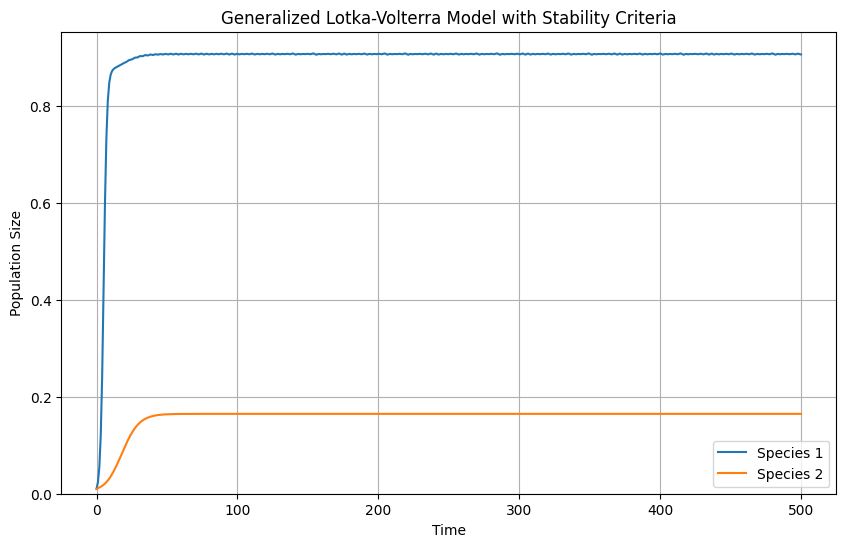

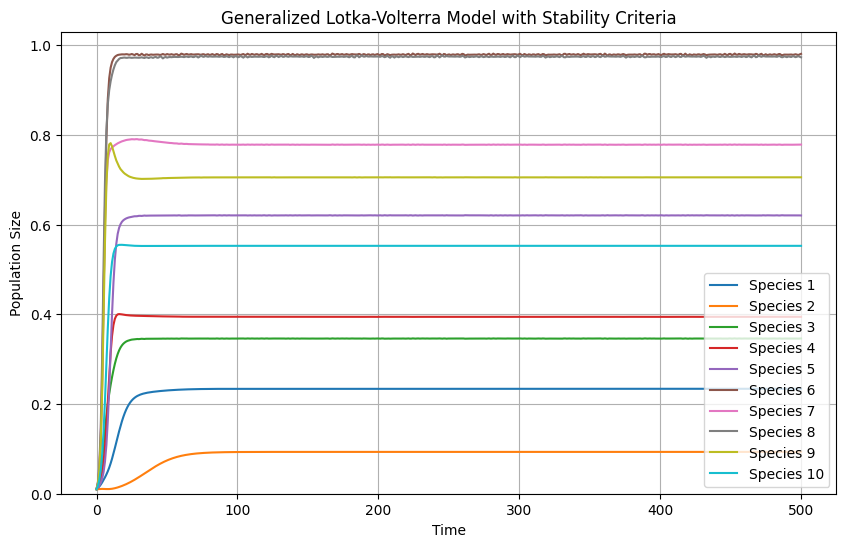

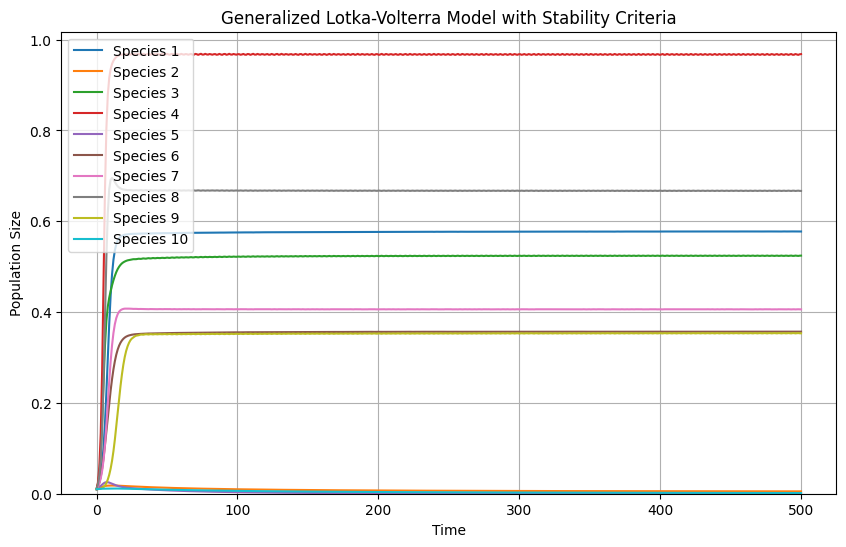

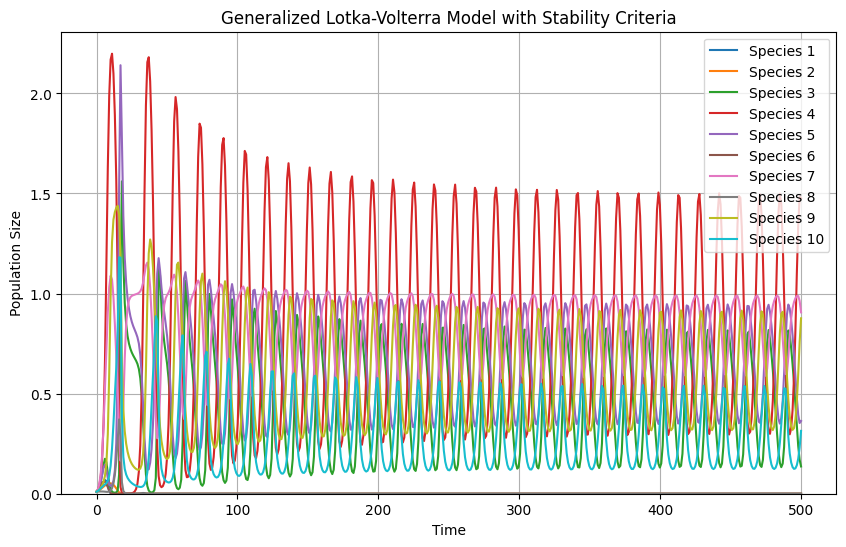

In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# GLV model function
def glv_model(t, N, r_values, a_values):
    dNdt = N * (r_values + np.dot(a_values, N))
    return dNdt

# Slider widget for the number of species
num_species_slider = widgets.IntSlider(
    value=2,
    min=2,
    max=10,  # Adjust as needed
    step=1,
    description='Number of Species:',
    continuous_update=True,
    readout=True,
    readout_format='d',
)
display(num_species_slider)

# Slider widget for the strength of interactions
strength_of_interactions_slider = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=5.0,  # Adjust as needed
    step=0.01,
    description='Interaction Strength:',
    continuous_update=True,
    readout=True,
    readout_format='.2f',
)
display(strength_of_interactions_slider)

# Slider widget for the connectance
connectance_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Connectance:',
    continuous_update=True,
    readout=True,
    readout_format='.2f',
)
display(connectance_slider)

# Output widget to display the stability criteria
stability_output = widgets.Output()
display(stability_output)

def update_stability_criteria(change):
    with stability_output:
        stability_output.clear_output()
        num_species = num_species_slider.value
        strength = strength_of_interactions_slider.value
        connectance = connectance_slider.value
        stability_criteria = strength * np.sqrt(num_species * connectance)
        print(f"Stability Criteria: {stability_criteria:.4f}")

# Initialize the stability criteria display
update_stability_criteria(None)

# Output widget to hold the parameter input boxes
parameters_output = widgets.Output()

def generate_species_inputs(num_species):
    # Lists to hold the input widgets
    growth_rate_inputs = []
    initial_population_inputs = []
    interaction_inputs = []

    # Create input boxes for intrinsic growth rates and initial populations
    for i in range(num_species):
        # Growth rate input for species i
        r_input = widgets.FloatText(
            value=np.random.uniform(),
            description=f'r_{i+1}:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='150px'),
        )
        growth_rate_inputs.append(r_input)

        # Initial population input for species i
        N0_input = widgets.FloatText(
            value= 0.01, #np.random.uniform(),
            description=f'N0_{i+1}:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='150px'),
        )
        initial_population_inputs.append(N0_input)

    # Create input boxes for interaction coefficients a_ij
    for i in range(num_species):
        row = []
        for j in range(num_species):
            if i != j:
                if np.random.rand() < connectance_slider.value:
                    a_value = np.random.normal(scale=strength_of_interactions_slider.value)
                else:
                    a_value = 0.0  # No interaction
            else:
                a_value = -1.0  # Default to negative self-interaction
            a_input = widgets.FloatText(
                value=a_value,
                description=f'a_{{{i+1},{j+1}}}:',
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='100px'),
            )
            row.append(a_input)
        interaction_inputs.append(row)

    return growth_rate_inputs, initial_population_inputs, interaction_inputs

def update_parameters(change):
    with parameters_output:
        clear_output()
        # Get the current number of species from the slider
        num_species = num_species_slider.value
        # Generate new input boxes based on the updated number of species
        r_inputs, N0_inputs, a_inputs = generate_species_inputs(num_species)

        # Organize inputs into a layout

        # Species parameters
        species_params = []
        for i in range(num_species):
            species_label = widgets.HTML(value=f"<b>Species {i+1}</b>")
            species_inputs = widgets.VBox([species_label, r_inputs[i], N0_inputs[i]])
            species_params.append(species_inputs)
        species_params_box = widgets.HBox(species_params)

        # Interaction coefficients
        interaction_grid = []
        for i in range(num_species):
            row = []
            for j in range(num_species):
                row.append(a_inputs[i][j])
            interaction_grid.append(widgets.HBox(row))
        interaction_label = widgets.HTML(value="<b>Interaction Coefficients (a<sub>ij</sub>)</b>")
        interaction_box = widgets.VBox([interaction_label] + interaction_grid)

        # Display all inputs
        display(widgets.VBox([species_params_box, interaction_box]))

        # Store inputs for further use
        parameters_output.r_inputs = r_inputs
        parameters_output.N0_inputs = N0_inputs
        parameters_output.a_inputs = a_inputs

    # Update the stability criteria
    update_stability_criteria(None)

# Observe changes in the sliders
num_species_slider.observe(update_parameters, names='value')
strength_of_interactions_slider.observe(update_parameters, names='value')
connectance_slider.observe(update_parameters, names='value')

num_species_slider.observe(update_stability_criteria, names='value')
strength_of_interactions_slider.observe(update_stability_criteria, names='value')
connectance_slider.observe(update_stability_criteria, names='value')

# Initialize the parameter inputs display
update_parameters(None)

# Display the parameter inputs
display(parameters_output)

def get_parameter_values():
    # Get the current parameter values
    r_values = [input_widget.value for input_widget in parameters_output.r_inputs]
    N0_values = [input_widget.value for input_widget in parameters_output.N0_inputs]
    num_species = len(r_values)

    # Interaction coefficients matrix
    a_values = np.zeros((num_species, num_species))
    for i in range(num_species):
        for j in range(num_species):
            a_values[i, j] = parameters_output.a_inputs[i][j].value

    return np.array(r_values, dtype=float), np.array(N0_values, dtype=float), a_values

def run_simulation(button):
    try:
        # Retrieve the parameter values
        r_values, N0_values, a_values = get_parameter_values()
        num_species = len(r_values)

        # Check for invalid inputs
        if np.any(N0_values < 0):
            raise ValueError("Initial populations must be non-negative.")

        # Time span and evaluation points
        t_span = (0, 500)
        t_eval = np.linspace(t_span[0], t_span[1], 500)

        # Solve the ODEs
        solution = solve_ivp(
            glv_model,
            t_span,
            N0_values,
            args=(r_values, a_values),
            t_eval=t_eval,
            method='RK45'
        )

        # Plot the results
        plt.figure(figsize=(10, 6))
        for i in range(num_species):
            plt.plot(solution.t, solution.y[i], label=f"Species {i+1}")
        plt.xlabel('Time')
        plt.ylabel('Population Size')
        plt.title('Generalized Lotka-Volterra Model with Stability Criteria')
        plt.legend()
        plt.grid(True)
        plt.ylim(bottom=0)
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Create a button to run the simulation
run_button = widgets.Button(
    description='Run Simulation',
    button_style='success',
    tooltip='Click to run the simulation with current parameters',
)
run_button.on_click(run_simulation)
display(run_button)
